[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aircable/xor-neural-network-demo/blob/main/cancer-detection-using-pytorch-96-accuracy.ipynb)

In [1]:
# Importing necessary libraries

import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

### GPU Availability

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


### Data Augmentation

In [3]:
imgSize = 112

# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),

    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),

    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Loading Dataset

## Step 1: Setting Up the Environment and Importing Data Sources

This Jupyter Notebook is designed for a skin cancer detection task and utilizes image datasets sourced from Kaggle, a popular platform for data science competitions and datasets.

To begin, we need to import the necessary data. The code cell below uses the `kagglehub.dataset_download` function. This function is part of the Kaggle API tools and serves a crucial purpose:
*   **`kagglehub.dataset_download`**: It connects to Kaggle, downloads the specified datasets, and makes them available within the notebook's environment for analysis and model training.

The datasets being imported are:
1.  **`fanconic/skin-cancer-malignant-vs-benign`**: This dataset likely contains images of skin lesions classified as either malignant (cancerous) or benign (non-cancerous).
2.  **`bhaveshmittal/melanoma-cancer-dataset`**: This dataset is focused on melanoma, a specific and dangerous type of skin cancer, providing more images for training our detection model.

Running the following code cell will ensure these datasets are ready for use in the subsequent steps of the notebook.

In [4]:
import kagglehub
import time

## Step 1: Setting Up the Environment and Importing Data Sources

# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# Download the first dataset
try:
    fanconic_skin_cancer_malignant_vs_benign_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')
    print('First dataset downloaded successfully.')
except Exception as e:
    print(f'Error downloading the first dataset: {e}')

# Attempt to download the second dataset with retries
max_retries = 3
for i in range(max_retries):
    try:
        bhaveshmittal_melanoma_cancer_dataset_path = kagglehub.dataset_download('bhaveshmittal/melanoma-cancer-dataset')
        print('Second dataset downloaded successfully.')
        break # Exit the loop if download is successful
    except Exception as e:
        print(f'Attempt {i+1} failed to download the second dataset: {e}')
        if i < max_retries - 1:
            print('Retrying in 5 seconds...')
            time.sleep(5) # Wait before retrying
        else:
            print('Max retries reached for the second dataset.')

print('Data source import complete (attempted downloads).')

First dataset downloaded successfully.
Second dataset downloaded successfully.
Data source import complete (attempted downloads).


In [5]:
path = '/kaggle/input/melanoma-cancer-dataset/train'
valPath = '/kaggle/input/melanoma-cancer-dataset/test'

trainData = datasets.ImageFolder(root = path, transform = transformer)
valData = datasets.ImageFolder(root = valPath, transform = valTransformer)

In [6]:
# Data loaders
batchSize = 128

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

# Defining Model

In [7]:
# Using a pre-trained EfficientNetV2L model
model = models.efficientnet_v2_s(weights = 'DEFAULT')

# Modifying final classifier layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

### Data Parallelism

In [8]:
# Remove this line if you are only using one GPU
# model = nn.DataParallel(model).to(device)
# Instead, just move the model to the device
model = model.to(device)

In [9]:
# Defining the loss, optimizer, and annealer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

### Early Stopping

In [10]:
patience = 5
minDelta = 0.01
currentPatience = 0
bestLoss = float('inf')

# Training Model

In [11]:
# Gradient scaler for mixed-precision training
scaler = GradScaler()

# Lists to store training and validation metrics
trainLosses = []
valLosses = []
valAccs = []

# Training loop
epochs = 30

for epoch in range(epochs):
    # Training phase
    model.train()
    runningLoss = 0.0

    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        runningLoss += loss.item()

    trainLoss = runningLoss / len(trainLoader)
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss : {trainLoss:.2f}')
    trainLosses.append(trainLoss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        valLoss = 0.0
        correct = total = 0

        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valLoss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avgLoss = valLoss / len(valLoader)
        accuracy = correct / total * 100

        print(f'Validation Loss : {avgLoss:.2f} Validation Accuracy : {accuracy:.2f}%\n')
        valLosses.append(avgLoss)
        valAccs.append(accuracy)

        # Early stopping
        if avgLoss < bestLoss - minDelta:
            bestLoss = avgLoss
            currentPatience = 0
        else:
            currentPatience += 1
            if currentPatience >= patience:
                print('Early stopping triggered.')
                break

        scheduler.step(avgLoss)

Epoch 1/30 - Training Loss : 0.29
Validation Loss : 0.29 Validation Accuracy : 85.55%

Epoch 2/30 - Training Loss : 0.22
Validation Loss : 0.31 Validation Accuracy : 87.50%

Epoch 3/30 - Training Loss : 0.21
Validation Loss : 0.23 Validation Accuracy : 90.35%

Epoch 4/30 - Training Loss : 0.19
Validation Loss : 0.20 Validation Accuracy : 91.85%

Epoch 5/30 - Training Loss : 0.18
Validation Loss : 0.17 Validation Accuracy : 93.15%

Epoch 6/30 - Training Loss : 0.17
Validation Loss : 0.16 Validation Accuracy : 93.85%

Epoch 7/30 - Training Loss : 0.16
Validation Loss : 0.22 Validation Accuracy : 90.75%

Epoch 8/30 - Training Loss : 0.15
Validation Loss : 0.24 Validation Accuracy : 89.85%

Epoch 9/30 - Training Loss : 0.14
Validation Loss : 0.14 Validation Accuracy : 95.10%

Epoch 10/30 - Training Loss : 0.13
Validation Loss : 0.20 Validation Accuracy : 90.85%

Epoch 11/30 - Training Loss : 0.12
Validation Loss : 0.12 Validation Accuracy : 95.70%

Epoch 12/30 - Training Loss : 0.12
Valida

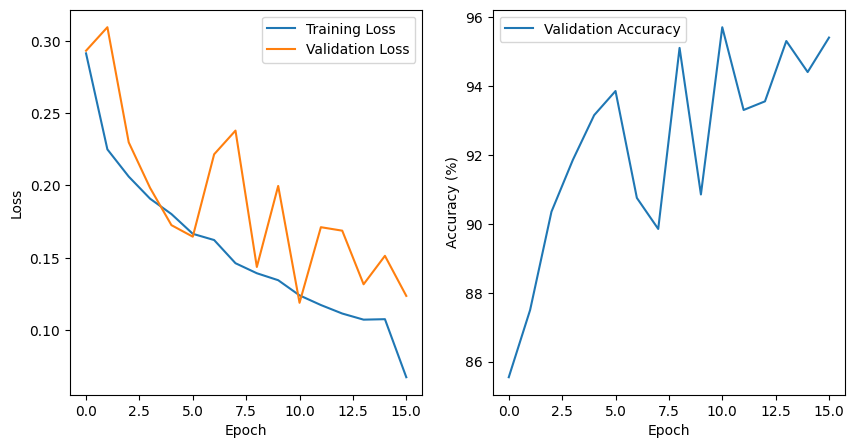

In [12]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses, label = 'Training Loss')
plt.plot(valLosses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

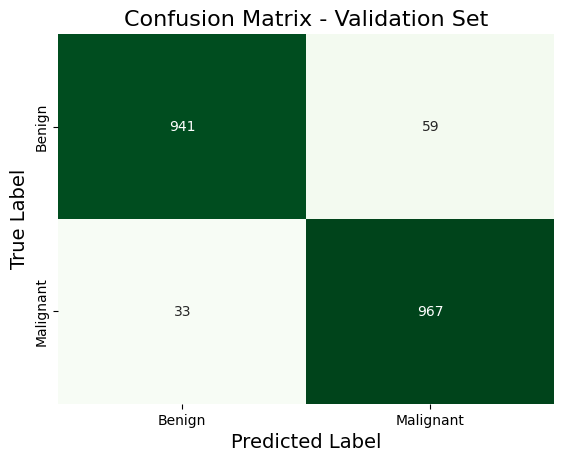

In [13]:
# Plotting confusion matrix for validation data
model.eval()
allLabels = []
allPreds = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)

sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

In [14]:
# Evaluate Model Size

# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

# Estimate model size in bytes (assuming float32 parameters)
# Each parameter (float32) takes 4 bytes
model_size_bytes = total_params * 4
print(f'Estimated model size (bytes, float32): {model_size_bytes}')

# Convert to megabytes for easier understanding
model_size_mb = model_size_bytes / (1024 * 1024)
print(f'Estimated model size (MB, float32): {model_size_mb:.2f}')

# Note: This is an estimate. The actual size might vary slightly due to model
# architecture details and the specific PyTorch version.

Total number of parameters: 20178769
Estimated model size (bytes, float32): 80715076
Estimated model size (MB, float32): 76.98


### Explanation and Implications for Embedded Systems:

This code calculates two key metrics related to model size:

1. Total Number of Parameters: This is the count of all the trainable weights and biases in your neural network.

  - Embedded Systems Relevance: A higher number of parameters generally means a larger model. Embedded systems often have limited memory (RAM and flash memory). A large model might not fit into the available memory, preventing it from being deployed on the device.

2. Estimated Model Size (Bytes/MB, float32): This is an estimate of the memory the model's parameters will occupy when stored as single-precision floating-point numbers (float32).

  - Embedded Systems Relevance: This gives you a concrete idea of how much storage space (flash memory) the trained model will require. Embedded systems have finite storage, and large models can quickly exceed this limit. This also impacts the amount of RAM needed to load and run the model.

### Why these metrics are important for embedded systems:

- **Memory Constraints:** Embedded systems are typically resource-constrained, with limited RAM and flash memory compared to desktop or server environments. Large models can be challenging to deploy due to these limitations.
- **Processing Power:** Larger models require more computational resources to perform inferences. Embedded processors are often less powerful than those found in other computing platforms. Running a large model on a low-power embedded processor can result in slow inference times, which might not be acceptable for real-time applications.
- **Power Consumption:** Running computationally intensive models on embedded systems can significantly increase power consumption, which is a critical concern for battery-powered devices.
Quantization: The concept you mentioned, quantization, is a key technique for deploying models on embedded systems. Quantization reduces the precision of the model's weights and activations (e.g., from float32 to int8 or int4). This has several benefits for embedded systems:
  - **Reduced Model Size:** Quantized models are significantly smaller, requiring less storage space.
  - **Reduced Memory Bandwidth:** Less data needs to be moved between memory and the processor.
  - **Faster Inference:** Many embedded processors have dedicated hardware accelerators for integer arithmetic, which can speed up inference with quantized models.
  - **Lower Power Consumption:** Integer operations are generally more power-efficient than floating-point operations.
### In summary:

The number of parameters and the estimated model size provide a baseline understanding of your model's memory footprint. For embedded systems, these metrics are crucial for determining if the model can be deployed on the target hardware. Techniques like quantization become essential to reduce model size and computational requirements to fit within the constraints of embedded devices.

After you run the code, you'll see the total parameters and the estimated size in MB. This will give you an idea of how large the EfficientNetV2S model is in its default float32 form and how much you might need to reduce its size through quantization for embedded deployment.

# Export model to ONNX format for embedded systems

In [16]:
!pip install onnx==1.14.0 # Or a recent compatible version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 40.5 MB/s eta 0:00:00


In [18]:
import torch
import torch.onnx
import os

# Mount Google Drive to access persistent storage
from google.colab import drive
drive.mount('/content/drive')

# Directory where models will be stored (in your Google Drive)
MODEL_DIR = '/content/drive/MyDrive/Notebooks/models'
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "efficientnet_v2_s_float32.onnx")

# Assuming 'model' is your trained float32 PyTorch model
# Assuming 'imgSize' is defined and is the input image size

# Set the model to evaluation mode
model.eval()

# Create a dummy input tensor with the correct shape (batch_size, channels, height, width)
# Use a batch size of 1 or the expected batch size for inference
dummy_input = torch.randn(1, 3, imgSize, imgSize).to(device) # Assuming 'device' is your device ('cuda' or 'cpu')

# Export the model to ONNX
# Specify the opset_version. A relatively recent version is usually good.
# input_names and output_names are optional but good practice for clarity
torch.onnx.export(model,                 # The trained model
                  dummy_input,           # A dummy input to trace the model
                  model_path, # Output file name
                  export_params=True,    # Export weights and biases
                  opset_version=13,      # ONNX opset version (choose one supported by your TFLite converter)
                  do_constant_folding=True, # Perform constant folding for optimization
                  input_names = ['input'], # Input layer name
                  output_names = ['output']) # Output layer name

print("Model exported to efficientnet_v2_s_float32.onnx")

Mounted at /content/drive
Model exported to efficientnet_v2_s_float32.onnx
